## In this notebook, we will
1. Build cross-validated Linear regression models.
2. Build cross-validated Ensemble regression models and optimize hyperparameters using GridSearch

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

## Load csv files into DataFrames
Data was previously split into training and testing sets in <font color='blue'>1.MolRedPot_FeatureEngineering.ipynb</font>

In [3]:
features=pd.read_csv('Data/features_train_scaled.csv')
target=pd.read_csv('Data/target_train.csv')['ERed']

In [4]:
print('Feature matrix shape: ',features.shape)
print('Target property shape: ',target.shape)

Feature matrix shape:  (4353, 32)
Target property shape:  (4353,)


## 5-fold cross-validated Linear Regression using entire dataset and report R2

In [5]:
# This cell executes CROSS-VALIDATED linear regression

lr = LinearRegression()
scores=cross_validate(lr,features,target,cv=5,return_train_score=True,scoring='r2')
scores

{'fit_time': array([0.02834368, 0.01517868, 0.0083425 , 0.01847076, 0.01213765]),
 'score_time': array([0.00344872, 0.00140452, 0.0080092 , 0.        , 0.00397348]),
 'test_score': array([0.77970622, 0.76707256, 0.76778659, 0.77741627, 0.74060763]),
 'train_score': array([0.76832083, 0.77139637, 0.77146951, 0.76918257, 0.77729148])}

In [11]:
print(np.mean(scores['train_score']),np.std(scores['train_score']))
print(np.mean(scores['test_score']),np.std(scores['test_score']))

0.7715321511523715 0.003131306936019811
0.7665178534611842 0.013899394629477582


## 5-fold cross-validated predictions using Linear Regression for entire dataset

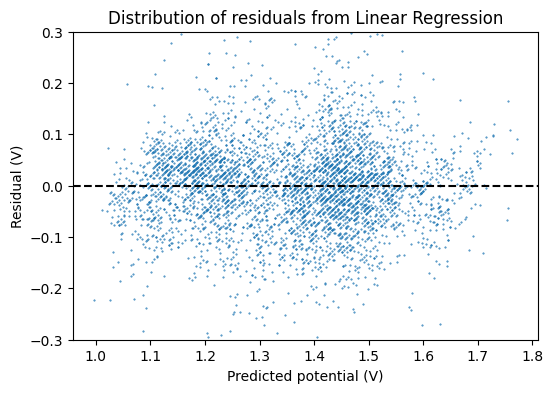

In [12]:
pot_pred=cross_val_predict(lr,features,target,cv=5)
plt.figure(figsize=(6,4))
plt.axhline(0,c='k',ls='--')
plt.scatter(pot_pred,pot_pred-target,s=0.2)
plt.ylim([-0.3,0.3])
plt.xlabel('Predicted potential (V)')
plt.ylabel('Residual (V)')
plt.title('Distribution of residuals from Linear Regression')
plt.show()

## Linear Regression model trained over the entire dataset

In [23]:
# This cell trains the entire dataset using Linear Regression.

lr = LinearRegression()
lr.fit(features,target)
ypred=lr.predict(features)
r2=np.round(r2_score(target,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig=px.scatter(x=target,y=ypred,
           range_x=[pot_min,pot_max],
           range_y=[pot_min,pot_max],
              width=500, height=500)
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash')
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)')
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)')
fig.update_layout(
    title="Linear Regression",
    xaxis_title="Reduction potential from DFT (V)",
    yaxis_title="Reduction potential from model (V)",
    legend_title="Legend Title",
    font=dict(
        size=16,
        color="RebeccaPurple"
    )
)
fig.update_layout(title='Linear Regression', title_x=0.5)
fig.add_annotation(
       
        text='R2 = '+str(r2),

        font=dict(
            size=16,
            color='red'
            ),
        showarrow=False,
         xref="paper", yref="paper",
        x=0.8, y=0.97
        
        )

fig.show()

## Save linear model

In [8]:
pickle.dump(lr, open('Models/LinearRegression.sav', 'wb'))

## Feature importances

In [9]:
fig = px.bar(list(features.columns), lr.coef_)
fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(features.columns))),
        ticktext = features.columns
    )
)
fig.update_xaxes(title='Coefficient')
fig.update_yaxes(title='Feature')
fig.update_layout(title='Feature importances from Linear Regression', title_x=0.5)
fig.show()

## Extract top 5 features with +ve and -ve correlation

In [10]:
df_feature=pd.DataFrame((list(features.columns), lr.coef_)).T
df_feature.columns=['Feature','Importance']
df_feature=df_feature.astype({'Importance':'float'})
feature_plus=df_feature.nlargest(5,'Importance')
feature_plus.index=range(5)
feature_down=df_feature.nsmallest(5,'Importance')
feature_down.index=range(5)

In [11]:
fig = make_subplots(rows=1, cols=2,horizontal_spacing=0.2, subplot_titles =['Positive correlation','Negative correlation'])

fig.add_trace(
    go.Bar(x=feature_plus['Importance'], y=feature_plus['Feature'], orientation='h'),
    row=1, col=1
)
fig.update_xaxes(title='Importance',row=1,col=1)
fig.update_yaxes(categoryorder = 'total ascending', row=1,col=1)

fig.add_trace(
    go.Bar(x=feature_down['Importance'], y=feature_down['Feature'], orientation='h'),
    row=1, col=2
)
fig.update_xaxes(title='Importance',row=1,col=2)
fig.update_yaxes(categoryorder = 'total descending', row=1,col=2)

fig.update_layout(height=400, width=1000)
fig.update_layout(showlegend=False)
fig.show()

## Ensemble regression (GBR): 5-fold, 5-time cross-validation
### Hyperparamter optimzation using Grid Search

In [12]:
%%time
# This cell executes a grid search to determine the best values for max_depth, n_estimators and the learning rate = 1.

gbr = GradientBoostingRegressor(learning_rate=1,max_depth=3,n_estimators=100)
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])
param_grid = {
    "gbr__learning_rate": np.logspace(-4, 0, 5),
    'gbr__max_depth':range(1,5),
    'gbr__n_estimators':range(100,500,100)
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,return_train_score=True,scoring='r2',cv=RepeatedKFold(n_splits=5, n_repeats=5,random_state=11))
search.fit(features, target)

CPU times: total: 7.66 s
Wall time: 12min 9s


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=11),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbr',
                                        GradientBoostingRegressor(learning_rate=1))]),
             n_jobs=-1,
             param_grid={'gbr__learning_rate': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'gbr__max_depth': range(1, 5),
                         'gbr__n_estimators': range(100, 500, 100)},
             return_train_score=True, scoring='r2')

In [13]:
print('Optimal hyperparameters from Grid Search\n')
for h in list(param_grid.keys()):
    print('\t',h,'=',search.best_params_[h])

Optimal hyperparameters from Grid Search

	 gbr__learning_rate = 0.1
	 gbr__max_depth = 4
	 gbr__n_estimators = 100


In [14]:
# This cell trains the entire dataset using the best gradient boosting hyperparameters. Since the grid search is more 
# time-consuming, the optimal hyperparameters are already provided with the training code. 

fig = make_subplots(rows=1, cols=2)
# The following line can be uncommented if the previous cell is executed for grid search optimisation.
# gbr=GradientBoostingRegressor(learning_rate=search.best_params_['gbr__learning_rate'],max_depth=search.best_params_['gbr__max_depth'],n_estimators=search.best_params_['gbr__n_estimators'])
gbr=GradientBoostingRegressor(learning_rate=0.1,max_depth=4,n_estimators=100)
gbr.fit(features,target)
ypred=gbr.predict(features)
r2=np.round(r2_score(target,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash', row=1, col=1
               )
fig.add_trace(go.Scatter(x=target,y=ypred,
                    mode='markers',showlegend=False,
                    ), row=1, col=1)
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)',row=1,col=1)
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)',row=1,col=1)
fig.add_annotation(
        text='R2 = '+str(r2),
        font=dict(
            size=12,
            color='red'
            ),
        showarrow=False,
        xref="paper", yref="paper",
        x=0.35, y=0.97        
        )
fig.update_layout(title='Ensemble regression using GBR & feature importances',title_x=0.5)
fig.add_trace(go.Bar(x=gbr.feature_importances_,y=list(range(features.shape[1])),text=features.columns,
                     orientation='h',showlegend=False),row=1,col=2)
fig.update_yaxes(tickmode='array',tickvals=list(range(features.shape[1])),ticktext=['']*8,row=1,col=2)
fig.show()

## Save ensemble model

In [15]:
pickle.dump(gbr, open('Models/EnsembleGBR.sav', 'wb'))

In the next notebook, <font color = blue>3.MolRedPot_NN.ipynb
</font>, we will develop feed forward neural network to predict the reduction potential of these molecules.